# Comparison between TRUST and BCR-seq

## Helper functions for reading repertoire data

In [1]:
%matplotlib inline

import os
import re
import gzip

import regex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def read_trust3_tsv_bcr(tsv):
    total=0.0
    with open(tsv, 'r') as f:
        f.readline() ## header
        for line in f:
            out = {}
            ele = line.split('\t')
            total += float(ele[2])
            
    with open(tsv, 'r') as f:
        f.readline() ## header
        for line in f:
            out = {}
            ele = line.split('\t')
            out['Freq'] = float(ele[2])/total
            out['Vgene'] = ele[3].split('_')[0].split('*')[0] ## first V gene
            out['Jgene'] = ele[4].split('_')[0].split('*')[0] ## first J gene
            out['Cgene'] = ele[5].split('_')[0].split('*')[0] ## first C gene
            glist = ele[6].split('_') ## genes from the aligner
            for agene in glist:
                if agene == '':
                    continue
                elif 'V' in agene:
                    out['Vgene'] = agene.split('|')[0].split('*')[0]
                elif 'J' in agene:
                    out['Jgene'] = agene.split('|')[0].split('*')[0]
                else: ## C genes
                    out['Cgene'] = agene.split('|')[0].split('*')[0]
            seq = ele[7]
            dna=ele[8]
            out['CDR3_aa'] = seq
            if out['Vgene']!='' or seq[0]=='C':
                dna = dna[3:]
            if out['Jgene']!='' or seq[-1]=='W':
                dna = dna[:-3]
            out['CDR3_DNA'] = dna
            out['contig_count'] = float(ele[11].strip())
            yield out

def read_irep(tab):
    total = 0.0
    with gzip.open(tab, 'rb') as f:
        head = f.readline().strip().split(',')
        freq_idx = head.index('copy')
        for line in f:
            ele = line.split(',')
            total += float(ele[freq_idx])
    with gzip.open(tab, 'rb') as f:
        head = f.readline().strip().split(',')
        freq_idx = head.index('copy')
        vgene_idx = head.index('V')
        jgene_idx = head.index('J')
        cgene_idx = head.index('C')
        aa_idx = head.index('CDR3(pep)')
        dna_idx = head.index('CDR3(nuc)')
        for line in f:
            out = {}
            ele = line.split(',')
            out['Freq'] = float(ele[freq_idx]) / total
            out['Vgene'] = ele[vgene_idx][1:]
            out['Jgene'] = ele[jgene_idx][1:]
            out['Cgene'] = ele[cgene_idx][1:]
            out['CDR3_aa'] = 'C'+ele[aa_idx]+'W'
            out['CDR3_DNA'] = ele[dna_idx].upper() ## DNA without C..W motif
            yield out

## Read the repertoire data 

In [2]:
def read_rep(f, format, keys=['CDR3_DNA', 'Freq', 'Cgene'], min_freq=0):
    if format == 'mixcr':
        read_fun = read_mixcr
    elif format == 'trust2':
        read_fun = read_trust2_bcr
    elif format == 'trust3':
        read_fun = read_trust3_tsv_bcr
    elif format == 'irep':
        read_fun = read_irep
    else:
        raise ValueError('Unknown file format '+format)
    rep = []
    for d in read_fun(f):
        if d['Freq'] <= min_freq:
            continue
        rep.append([d[i] for i in keys])
    print 'Read', len(rep), 'unique clones from', f
    return rep
  
def get_reps(names=['FZ-20','FZ-83','FZ-97', 'FZ-94', 'FZ-116', 'FZ-122']):
    p1 = './iRep/' 
    p2 = './TRUST3/'
    reps = []
    
    for f in sorted(os.listdir(p1)):
        for name in names:
            if f.endswith('.csv.gz') and name in f:
                reps.append(('BCRseq', name, read_rep(p1+f, format='irep')))
                break
    
    for f in sorted(os.listdir(p2)):
        for name in names:
            if f.endswith('.fa.txt') and name in f:
                reps.append(('TRUST', name, read_rep(p2+f, format='trust3')))
                break
    print 'We have', len(reps), 'repertoires'
    return reps

reps = get_reps()

Read 737373 unique clones from ./iRep/FZ-116.csv.gz
Read 567794 unique clones from ./iRep/FZ-122.csv.gz
Read 683642 unique clones from ./iRep/FZ-20.csv.gz
Read 865035 unique clones from ./iRep/FZ-83.csv.gz
Read 674929 unique clones from ./iRep/FZ-94.csv.gz
Read 638432 unique clones from ./iRep/FZ-97.csv.gz
Read 5290 unique clones from ./TRUST3/FZ-116.Aligned.sortedByCoord.out.bam-BCR-HeavyChain.fa.txt
Read 1923 unique clones from ./TRUST3/FZ-122.Aligned.sortedByCoord.out.bam-BCR-HeavyChain.fa.txt
Read 3428 unique clones from ./TRUST3/FZ-20.Aligned.sortedByCoord.out.bam-BCR-HeavyChain.fa.txt
Read 9290 unique clones from ./TRUST3/FZ-83.Aligned.sortedByCoord.out.bam-BCR-HeavyChain.fa.txt
Read 7894 unique clones from ./TRUST3/FZ-94.Aligned.sortedByCoord.out.bam-BCR-HeavyChain.fa.txt
Read 2999 unique clones from ./TRUST3/FZ-97.Aligned.sortedByCoord.out.bam-BCR-HeavyChain.fa.txt
We have 12 repertoires


## Helper funcions for evaluating the performance

In [3]:
def align_rep(s1, s2, mismatch=1):
    """ Align the two repretoires based on CDR3s
    """
    out = {}
    for seq in s1:
        pat=regex.compile('('+seq+'){s<=%s}'%mismatch)
        match=filter(pat.match, s2)
        if match:
            out[seq] = match
        else:
            out[seq] = 'None'
    return out

def rep2dict(r1, I, J):
    d1 = {}
    for e in r1:
        if e[I] == '' or '*' in e[I] or '_' in e[I]:
            continue
        if e[I] in d1:
            d1[e[I]] += e[J]
        else:
            d1[e[I]] = e[J]
    return d1

def get_precision(match, rep_d, min_freq):
    
    s_rep_d=sorted(rep_d.items(),key=lambda e:e[1],reverse=True) 
    res=[]
    for key, value in s_rep_d:
        res.append(match[key])
        if value < min_freq:
            break
            
    return 1-res.count('None')/float(len(res))

def get_sensitivity(match, rep_d, min_freq, thro=1e-5):
    
    rep_d_top={}
    
    for key, value in rep_d.items():
        if value >= thro:
            rep_d_top[key]=value
            
    match_r={}
    matched_rep=[]
    
    for i in match.values():
        if isinstance(i,list):
            for j in i:
                matched_rep.append(j)
        else:
            matched_rep.append(i)
            
    for key, value in rep_d_top.items():
        if key in matched_rep:
            match_r[key]='Valid'
        else:
            match_r[key]='None'
            
    s_rep_d=sorted(rep_d_top.items(),key=lambda e:e[1],reverse=True) 
    res=[]
    for key, value in s_rep_d:
        res.append(match_r[key])
        if value < min_freq:
            break
            
    return 1-res.count('None')/float(len(res))

## Obtain precision and recalls 

In [4]:
def compare_TRUST_BCRseq(reps, cutoffs, M=0):
    precision = pd.DataFrame()
    sensitivity = pd.DataFrame()
    for s1, f1, r1 in reps:
        if s1 != 'TRUST':
            continue
        for s2, f2, r2 in reps:
            if s2 != 'BCRseq':
                continue
            if f2 in f1: ## same sample
                print f1
                d1 = rep2dict(r1, I=0, J=1)
                d2 = rep2dict(r2, I=0, J=1)
                match = align_rep(d1.keys(), d2.keys(), mismatch=M)
                pre=[get_precision(match, d1, i) for i in cutoffs]
                sen=[get_sensitivity(match, d2, i) for i in cutoffs]
                precision[f1] = pre
                sensitivity[f1] = sen
    return (precision, sensitivity)

cutoffs=[0.1, 0.01, 1e-3, 1e-4, 1e-5]

precision, sensitivity = compare_TRUST_BCRseq(reps, cutoffs, M=1)

FZ-116
FZ-122
FZ-20
FZ-83
FZ-94
FZ-97


     FZ-116    FZ-122     FZ-20     FZ-83     FZ-94     FZ-97
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
1  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
2  0.935484  0.740741  0.981308  0.900000  0.900000  0.875000
3  0.537209  0.557724  0.558766  0.659797  0.651490  0.518256
4  0.533065  0.557724  0.557147  0.531076  0.526445  0.515562


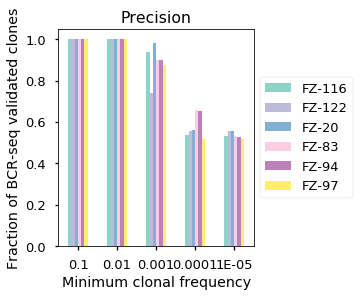

In [5]:
plt.style.use('seaborn-talk')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

ax = precision.plot(kind='bar', colormap='Set3', figsize=(3.5,4), rot=0, legend=False)
ax.set_xticklabels(['%.0G'%i for i in cutoffs])
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set(title='Precision', xlabel='Minimum clonal frequency', ylabel='Fraction of BCR-seq validated clones')
print(precision)

     FZ-116    FZ-122     FZ-20     FZ-83     FZ-94     FZ-97
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000
1  1.000000  0.875000  0.625000  1.000000  0.600000  0.700000
2  0.764706  0.738095  0.822785  0.831169  0.761194  0.647541
3  0.442704  0.494652  0.753754  0.686491  0.588333  0.473625
4  0.233083  0.400835  0.520542  0.542138  0.423496  0.290112


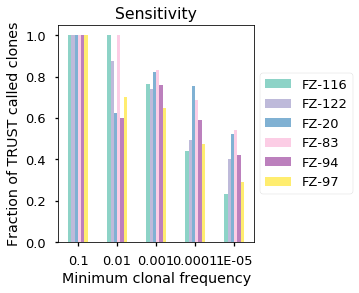

In [6]:
ax = sensitivity.plot(kind='bar', colormap='Set3', figsize=(3.5,4), rot=0, legend=False)
ax.set_xticklabels(['%.0G'%i for i in cutoffs])
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set(title='Sensitivity', xlabel='Minimum clonal frequency', ylabel='Fraction of TRUST called clones')
print(sensitivity)

## Overview overlaps

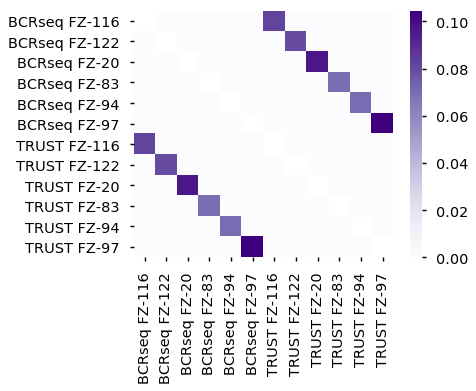

In [7]:
def Jaccard_index(r1, r2, I=0, J=1, min_freq=1e-5):
    '''
    Args: I, index of CDR3aa
          J, index of frequency
          min_freq, cutoff for the minimum frequency
    '''
    d1 = set([e[I] for e in r1 if e[J] >= min_freq])
    d2 = set([e[I] for e in r2 if e[J] >= min_freq])
    return len(d1&d2) / float(len(d1|d2))

def plot_heatmap(reps, case, title='', new_run=True):
    save = 'heatmap_'+case+'.csv'
    if not new_run and os.path.exists(save):
        res = pd.read_csv(save)
    else:
        res = []
        for s1, n1, r1 in reps:
            for s2, n2, r2 in reps:
                if case == 'JC':
                    score = Jaccard_index(r1,r2)
                else:
                    raise ValueError('Unknown case '+case)
                res.append((s1, s1+' '+n1, s2, s2+' '+n2, score))
        res = pd.DataFrame(res, columns=['Set1', 'Sample1', 'Set2', 'Sample2', 'Score'])
        #res.to_csv(save, index=False)
    res.loc[res.Sample1 == res.Sample2, 'Score'] = np.nan ## ignore self correlation
    mat = res.pivot(index='Sample1', columns='Sample2', values='Score')
    fig, ax = plt.subplots(figsize=(6,5), dpi=80)
    sns.heatmap(mat, cmap="Purples", ax=ax)
    plt.xticks(rotation=90)
    ax.set(title=title, xlabel='', ylabel='')
    fig.tight_layout()

plot_heatmap(reps, 'JC')

## Evaluate the Ig isotypes

FZ-116 iRep = 737373 TRUST = 5290 Common = 741
FZ-122 iRep = 567794 TRUST = 1923 Common = 226
FZ-20 iRep = 683642 TRUST = 3428 Common = 397
FZ-83 iRep = 865035 TRUST = 9290 Common = 1306
FZ-94 iRep = 674929 TRUST = 7894 Common = 1096
FZ-97 iRep = 638432 TRUST = 2999 Common = 313


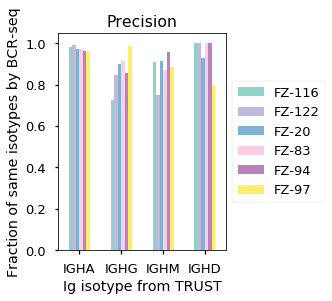

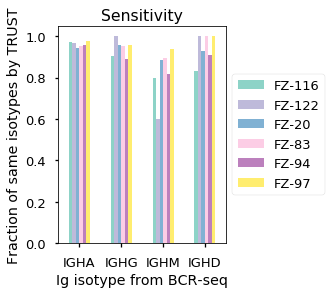

In [8]:
def matched_cgenes(r1, r2, i=0, j=2, nosub=True):
    '''
    Args: i, index of CDR3aa; j, index of constant genes
    '''
    c1 = {}
    for e in r1:
        s = e[i]
        c = e[j].split('*')[0]
        if s == '' or c == '':
            continue
        if nosub:
            c = c[:4] ## ignore subtypes
        if s in c1:  
            c1[s].add(c)
        else:
            c1[s] = set([c])
    c2 = {}
    for e in r2:
        s = e[i]
        c = e[j].split('*')[0]
        if s == '' or c == '':
            continue
        if nosub:
            c = c[:4] ## ignore subtypes
        if s in c2:  
            c2[s].add(c)
        else:
            c2[s] = set([c])            
    for seq in c1:
        if seq in c2:
            o1 = c1[seq]
            o2 = c2[seq]
            if len(o1) == 1 and len(o2) == 1: ## only one C gene
                yield list(o1)[0], list(o2)[0]
                
def check_cgene(reps, title='', iglist=['IGHA','IGHG','IGHM','IGHD']):
    precision = pd.DataFrame()
    sensitivity = pd.DataFrame()
    for s1, f1, r1 in reps:
        if s1 != 'BCRseq':
            continue
        for s2, f2, r2 in reps:
            if s2 != 'TRUST':
                continue
            if f2 in f1: ## same sample
                count = {}
                for p in matched_cgenes(r1, r2):
                    if p in count:
                        count[p] += 1
                    else:
                        count[p] = 1
                print f2, 'iRep =', len(r1), 'TRUST =', len(r2), 'Common =', sum(count.values())
                TP = np.array([count.get((i,i),0) for i in iglist], dtype='float')
                bP = np.array([sum([count.get((i,j),0) for j in iglist]) for i in iglist], dtype='float')
                tP = np.array([sum([count.get((j,i),0) for j in iglist]) for i in iglist], dtype='float')
                precision[f2] = TP/tP  ## True positive out of all predicted by TRUST
                sensitivity[f2] = TP/bP ## True positive out of all labeled by BCR-seq
    precision['isotype'] = iglist
    sensitivity['isotype'] = iglist
    precision.set_index('isotype', inplace=True)   
    sensitivity.set_index('isotype', inplace=True)   
    return precision, sensitivity

pre, sen = check_cgene(reps)

ax = pre.plot(kind='bar', colormap='Set3', figsize=(3,4), rot=0, legend=False)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set(title="Precision", xlabel='Ig isotype from TRUST', ylabel='Fraction of same isotypes by BCR-seq')

ax = sen.plot(kind='bar', colormap='Set3', figsize=(3,4), rot=0)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set(title="Sensitivity", xlabel='Ig isotype from BCR-seq', ylabel='Fraction of same isotypes by TRUST')